# Pre-entrainement d'un mini GPT


## 1. Imports et configuration globale

In [ ]:
from dataclasses import replace
from pathlib import Path
import time

import matplotlib.pyplot as plt
import torch

from gptlight.config import GPT2_CONFIG_124M
from gptlight.datasets import fetch_verdict_text
from gptlight.models import GPTModel
from gptlight.tokenizer import GPTTokenizer
from gptlight.training import Trainer
from gptlight.training.checkpoint import save_model
from gptlight.training.loss import llm_loss
from gptlight.utils import create_dataloader, generate_text_simple


In [149]:
torch.manual_seed(123)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entrainement sur: {device}")


Entrainement sur: cpu


## 2. Configuration du modele
La configuration GPT-2 "124M" est reprise telle quelle, avec une longueur de contexte reduite pour rester compatible avec une machine locale.


In [150]:
cfg = replace(
    GPT2_CONFIG_124M,
    context_length=256,
    drop_rate=0.1,
)

model = GPTModel(cfg).to(device)
tokenizer = GPTTokenizer()

num_params = sum(p.numel() for p in model.parameters())
print(f"Nombre total de parametres: {num_params:,}")
print(f"Longueur de contexte: {cfg.context_length} tokens")


Nombre total de parametres: 247,446,528
Longueur de contexte: 256 tokens


## 3. Evaluer un modele non entraine
Cette etape illustre le comportement aleatoire d'un modele initialise, histoire de motiver la phase d'apprentissage.


In [151]:
torch.manual_seed(123)
prompt = "Every effort moves you"
start_ids = tokenizer.encode(prompt).to(device)

generated_ids = generate_text_simple(
    model=model,
    idx=start_ids,
    max_new_tokens=40,
    context_size=cfg.context_length,
)

generated_text = tokenizer.decode(generated_ids[0].cpu())
print(generated_text)


Every effort moves youumper ear announce emptiness granddaughterervatives subjug superintendentSomething� hornツ completing Buy=$ Observercmp quant justice TNT La vaccination poured 307 appointment mentorredit pedestosa unsur)]. leve arsen Founding Melt Pv aiming Freeze PCs Moe


La sortie ressemble a `Every effort moves youumper ear announce emptiness granddaughterervatives subjug superintendentSomething� horn`, preuve que le reseau non entraine assemble des mots sans coherence.


## 4. Comprendre la cross-entropy

In [152]:
example_texts = [
    "Every effort moves you forward",
    "I really like pizza on rainy days",
]

encoded = [tokenizer.encode(text).squeeze(0) for text in example_texts]
min_tokens = min(len(ids) for ids in encoded) - 1
inputs = torch.stack([ids[:min_tokens] for ids in encoded])
targets = torch.stack([ids[1:min_tokens + 1] for ids in encoded])

with torch.inference_mode():
    logits = model(inputs.to(device)).cpu()

probas = torch.softmax(logits, dim=-1)
target_probas = torch.gather(
    probas,
    dim=2,
    index=targets.unsqueeze(-1),
).squeeze(-1)

log_target_probas = torch.log(target_probas + 1e-9)
avg_log_proba = log_target_probas.mean()
manual_loss = -avg_log_proba
auto_loss = llm_loss(logits, targets)

print(f"Log-proba moyenne des tokens cibles: {avg_log_proba:.4f}")
print(f"Perte manuelle (NLL): {manual_loss:.4f}")
print(f"llm_loss: {auto_loss:.4f}")


Log-proba moyenne des tokens cibles: -11.0679
Perte manuelle (NLL): 11.0679
llm_loss: 11.0680


## 5. Charger le corpus avec l'utilitaire

In [153]:
raw_text = fetch_verdict_text()

print(f"Nombre de caracteres: {len(raw_text):,}")
print(raw_text[:400])


Nombre de caracteres: 20,479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear


## 6. Jeu d'entrainement vs validation

In [154]:
train_ratio = 0.90
split_idx = int(len(raw_text) * train_ratio)
train_data = raw_text[:split_idx]
val_data = raw_text[split_idx:]

print(f"Taille train (caracteres): {len(train_data):,}")
print(f"Taille val   (caracteres): {len(val_data):,}")


Taille train (caracteres): 18,431
Taille val   (caracteres): 2,048


### DataLoader pour GPT


In [161]:
batch_size = 2
stride = cfg.context_length

train_loader = create_dataloader(
    txt=train_data,
    batch_size=batch_size,
    max_length=cfg.context_length,
    stride=stride,
    shuffle=True,
    drop_last=True,
)

val_loader = create_dataloader(
    txt=val_data,
    batch_size=batch_size,
    max_length=cfg.context_length,
    stride=stride,
    shuffle=False,
    drop_last=False,
)

example_inputs, example_targets = next(iter(train_loader))
print(f"Input batch shape: {example_inputs.shape}")
print(f"Target batch shape: {example_targets.shape}")
print(f"Nombre de batches train: {len(train_loader)}")
print(f"Nombre de batches val:   {len(val_loader)}")


Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Nombre de batches train: 9
Nombre de batches val:   1


## 7. Lancer l'entrainement
La classe `Trainer` standardise la boucle epochs, le clipping de gradient et la journalisation des pertes.


In [162]:
num_epochs = 10
learning_rate = 3e-4
grad_clip = 1.0
eval_every = 1

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=0.1,
)

trainer = Trainer(
    model=model,
    optimizer=optimizer,
    device=device,
    grad_clip=grad_clip,
)

start_time = time.perf_counter()
history = trainer.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    eval_every=eval_every,
    verbose=True,
)
training_time = time.perf_counter() - start_time
print(f"Temps total: {training_time:.1f} s")


[Epoch 1/10] train_loss=9.2938 | val_loss=8.0347
[Epoch 2/10] train_loss=6.9251 | val_loss=6.6275
[Epoch 3/10] train_loss=5.8393 | val_loss=6.3704
[Epoch 4/10] train_loss=5.0066 | val_loss=6.1969
[Epoch 5/10] train_loss=4.0730 | val_loss=6.2276
[Epoch 6/10] train_loss=3.2036 | val_loss=6.1904
[Epoch 7/10] train_loss=2.3667 | val_loss=6.2806
[Epoch 8/10] train_loss=1.6497 | val_loss=6.4501
[Epoch 9/10] train_loss=1.0696 | val_loss=6.4008
[Epoch 10/10] train_loss=0.6565 | val_loss=6.5859
Temps total: 754.3 s


## 8. Visualiser la courbe d'apprentissage

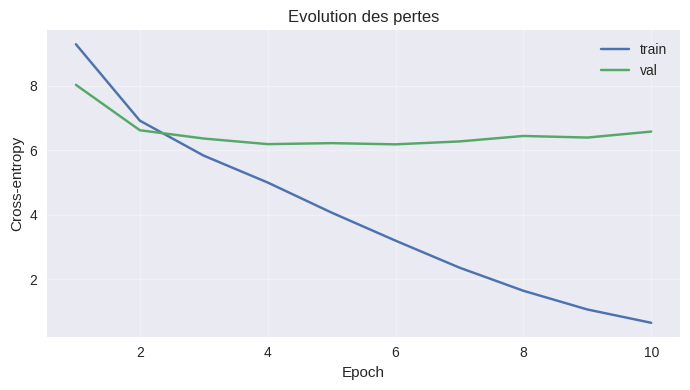

In [163]:
def plot_learning_curve(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.style.use("seaborn-v0_8")
    plt.figure(figsize=(7, 4))
    plt.plot(epochs, history["train_loss"], label="train")
    if "val_loss" in history:
        plt.plot(epochs, history["val_loss"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Cross-entropy")
    plt.title("Evolution des pertes")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_learning_curve(history)


## 9. Generer du texte apres entrainement
Cette section verifie que la baisse de perte se traduit bien par une generation plus coherente.


In [166]:
torch.manual_seed(42)
prompt = "That was his history."
start_ids = tokenizer.encode(prompt).to(device)
pre_trained_model = trainer.model

generated_ids = generate_text_simple(
    model=pre_trained_model,
    idx=start_ids,
    max_new_tokens=60,
    context_size=cfg.context_length,
)

print(tokenizer.decode(generated_ids[0].cpu()))


That was his history. It was not that my hostess was "interesting": on that point I could have given Miss Croft the fullest reassurance. It was just because she was _not_ interesting--if I saw that, when Stroud laid in the first stroke, he knew just what the end would be.


## 10. Sauvegarder un checkpoint reutilisable

In [180]:
checkpoint_dir = Path("checkpoints")
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "pretraining-demo.pt"

save_model(
    model=trainer.model,
    path=str(checkpoint_path),
    #optimizer=trainer.optimizer,
    #epoch=len(history["train_loss"]),
)

print(f"Checkpoint enregistre dans {checkpoint_path}")


Checkpoint enregistre dans checkpoints/pretraining-demo.pt
